In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as pld
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cust_mon = pd.read_csv('cust_bet_mon.csv')
cust_mon.head()

,accountno,total_betamount,total_validationamount,month
0,100134,80.00,47.00,9
1,100183,400.00,0.00,9
2,100213,47149.79,39480.37,9
3,100237,140.00,144.00,9
4,100286,210.00,0.00,9


#### Format to 1 digit

In [4]:
cust_mon['total_betamount'] = pd.to_numeric(cust_mon['total_betamount'].apply(lambda x: '{0:.1f}'.format(x)))
cust_mon['total_validationamount'] = pd.to_numeric(cust_mon['total_validationamount'].apply(lambda x: '{0:.1f}'.format(x)))

In [5]:
cust_mon['wining'] = cust_mon['total_validationamount']-cust_mon['total_betamount']

#### Apply minmax_scale to normalize stake

In [59]:
from sklearn.preprocessing import minmax_scale

In [21]:
cust_mon['norm_betamount'] = cust_mon.groupby('accountno')['total_betamount'].transform(lambda x: minmax_scale(x))
cust_mon['norm_wining'] = cust_mon.groupby('accountno')['wining'].transform(lambda x: minmax_scale(x))

cust_mon.head()

,accountno,total_betamount,total_validationamount,month,wining,norm_betamount,norm_wining
0,100134,80.0,47.0,9,-33.0,0.000000,0.523699
1,100183,400.0,0.0,9,-400.0,0.000000,0.669860
2,100213,47149.8,39480.4,9,-7669.4,0.753550,0.215232
3,100237,140.0,144.0,9,4.0,0.000000,0.113263
4,100286,210.0,0.0,9,-210.0,0.038432,0.733833


#### Compute std of every customer

In [27]:
cust_mon['betamount_std'] = cust_mon.groupby('accountno')['norm_betamount'].transform(lambda x: np.std(x))
cust_mon['wining_std'] = cust_mon.groupby('accountno')['norm_wining'].transform(lambda x: np.std(x))

#### Delete non-active customers(at least active 6 months)

In [34]:
cust_mon['occurence'] = cust_mon.groupby('accountno')['accountno'].transform(lambda x: len(x))

In [40]:
cust_mon_active = cust_mon[cust_mon['occurence']>5]
cust_mon_active.shape

(109052, 10)

#### Is the deviation low? Do they have a fixed wallet?

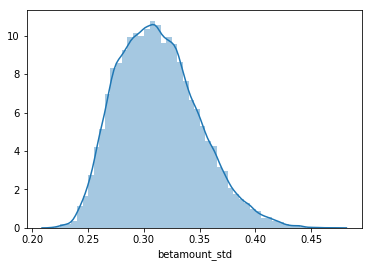

In [41]:
sns.distplot(cust_mon_active['betamount_std'])

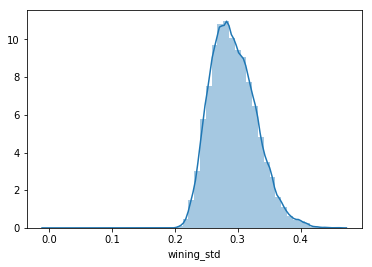

In [42]:
sns.distplot(cust_mon_active['wining_std'])

#### How to measure fix wallet?
Now that every bettor's expense is normalized into [0, 1] scale, so to measure the fluactuation, no matter how much they spent, we should only care about how much is the deviation. So I would say CV can not be applied here, because the data has already been normalized.

In [35]:
cust_mon_active.to_csv('cust_mon_active.csv', index=False)

In [57]:
cust_mon_active = pd.read_csv('cust_mon_active.csv')
cust_mon_active.head(3)

,accountno,total_betamount,total_validationamount,month,wining,norm_betamount,norm_wining,wining_std,betamount_std,occurence
0,100183,400.0,0.0,9,-400.0,0.00000,0.669860,0.265783,0.297886,12
1,100213,47149.8,39480.4,9,-7669.4,0.75355,0.215232,0.274805,0.289391,12
2,100237,140.0,144.0,9,4.0,0.00000,0.113263,0.343138,0.301409,9


In [39]:
cust_mon_active['sap_std_betamount'] = cust_mon_active.groupby('accountno')['norm_betamount'].\
                    transform(lambda x: np.sqrt((np.std(x)**2)*(len(x)-1)/len(x)))

#### I hope to compute a confience interval for every bettor, simple each bettor the sample size is small, t-distribution is applied here
Estimating the expense CI of every bettor, the degree of freedom is their month occurence, and scale is standard error of mean. Estimation is based on every bettor's mean expense

In [14]:
from scipy.stats import t
from scipy import stats

In [27]:
cust_mon_active['lower_bound']= cust_mon_active.groupby('accountno')['norm_betamount'].\
                transform(lambda x: t.interval(.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x))[0])

In [28]:
cust_mon_active['upper_bound']= cust_mon_active.groupby('accountno')['norm_betamount'].\
                transform(lambda x: t.interval(.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x))[1])

In [30]:
cust_mon_active['diff'] = cust_mon_active['upper_bound'] - cust_mon_active['lower_bound'] 

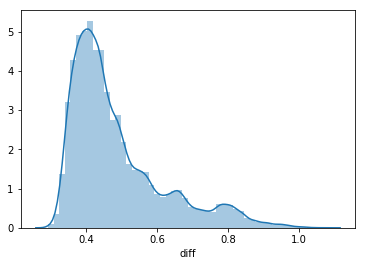

In [31]:
sns.distplot(cust_mon_active['diff'])

##### Difference is big, maybe no fixed wallet

## Start Here

In [6]:
cust_mon_active = pd.read_csv('cust_mon_active.csv')
cust_mon_active.head()  # all months included

,accountno,total_betamount,total_validationamount,month,wining,norm_betamount,norm_wining,wining_std,betamount_std,occurence
0,100183,400.0,0.0,9,-400.0,0.000000,0.669860,0.265783,0.297886,12
1,100213,47149.8,39480.4,9,-7669.4,0.753550,0.215232,0.274805,0.289391,12
2,100237,140.0,144.0,9,4.0,0.000000,0.113263,0.343138,0.301409,9
3,100286,210.0,0.0,9,-210.0,0.038432,0.733833,0.254449,0.371326,11
4,100316,500.0,0.0,9,-500.0,0.125000,0.285714,0.295853,0.306319,12


In [7]:
month_market = cust_mon.groupby('month', as_index=False).agg({'total_betamount': 'sum'})

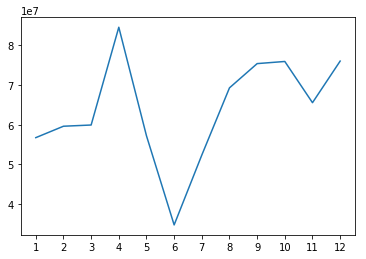

In [52]:
fig, ax = plt.subplots()
ax.plot(month_market['month'], month_market['total_betamount'])

ax.set_xticks(range(1, 13))

#### Normalize each bettor's expense by the total market size, and then compare the dispersion

In [8]:
month_market['market_norm'] = month_market['total_betamount']/np.min(month_market['total_betamount'])

In [9]:
cust_mon_active = cust_mon_active.merge(month_market[['month', 'market_norm']], on='month')
cust_mon_active['norm_betamount_month'] = cust_mon_active['norm_betamount']/cust_mon_active['market_norm']
cust_mon_active['norm_wining_month'] = cust_mon_active['norm_wining']/cust_mon_active['market_norm']

##### See the variation in spite of month factor 

In [10]:
betamount_std_without_month = cust_mon_active.groupby('accountno', as_index=False).agg({'norm_betamount_month': 'std'})['norm_betamount_month']
wining_std_without_month = cust_mon_active.groupby('accountno', as_index=False).agg({'norm_wining_month': 'std'})['norm_wining_month']

betamount_std_with_month = cust_mon_active.groupby('accountno', as_index=False).agg({'norm_betamount': 'std'})['norm_betamount']
wining_std_with_month = cust_mon_active.groupby('accountno', as_index=False).agg({'norm_wining': 'std'})['norm_wining']

In [11]:
wining_std_without_month = wining_std_without_month[wining_std_without_month>0]
wining_std_with_month = wining_std_with_month[wining_std_with_month>0]

##### Variation with month excluded

Text(0.5,0,'')

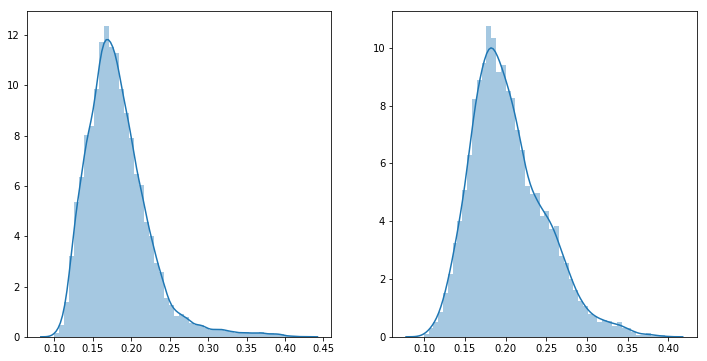

In [90]:
fig = plt.figure(figsize=[12, 6])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

g1 = sns.distplot(betamount_std_without_month, ax=ax1)
g2 = sns.distplot(wining_std_without_month, ax=ax2)

g1.set_xlabel('')
g2.set_xlabel('')

##### Variation with month included

Text(0.5,0,'')

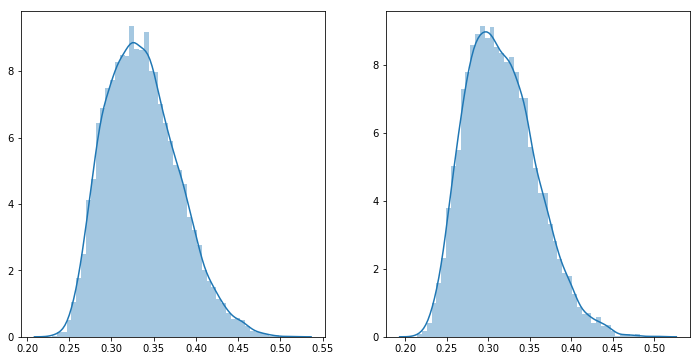

In [89]:
fig = plt.figure(figsize=[12, 6])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

g1 = sns.distplot(betamount_std_with_month, ax=ax1)
g1.set_xlabel('')

g2 = sns.distplot(wining_std_with_month, ax=ax2)
g2.set_xlabel('')

#### Combine Plot

##### bet amount

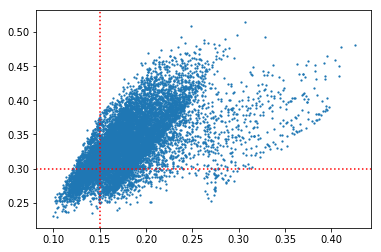

In [17]:
fig, ax = plt.subplots()
plt.scatter(betamount_std_without_month, betamount_std_with_month, s=1.5)

ax.axhline(y=0.3, linewidth=1.5, color='r', linestyle=':')
ax.axvline(x=0.15, linewidth=1.5, color='r', linestyle=':')

##### wining

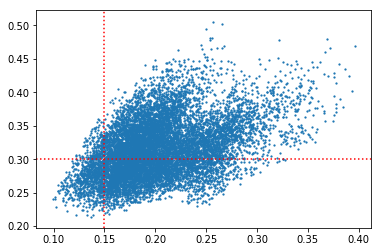

In [19]:
fig, ax = plt.subplots()
plt.scatter(wining_std_without_month, wining_std_with_month, s=1.5)

ax.axhline(y=0.3, linewidth=1.5, color='r', linestyle=':')
ax.axvline(x=0.15, linewidth=1.5, color='r', linestyle=':')